<a href="https://colab.research.google.com/github/JaiVR/suttmltask_1/blob/main/suttml_task1_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1290]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [1291]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [1292]:
dataset= pd.read_csv('sutt.csv')

In [1293]:
#fixing the casing issues in club/dept. column
def replace_value(value):
    if value == 's':
        return 'sutt'
    elif value == 'd' or value == 'v':
        return 'dvm'
    elif value == 'g':
        return 'gaming club'
    elif value == 'm':
        return 'mountaineering club'
    else:
        return value


dataset[' CLUB / DEPARTMENT'] = dataset[' CLUB / DEPARTMENT'].str.lower().str[0].apply(replace_value)

In [1294]:
X = dataset.drop(['BIRTHDAY', 'DAYS SINCE LAST SHOWER', 'TREATS GIVEN','PIZZERIA EXPENDITURE (annual)', 'GPL'], axis=1)
#y --> dependent variable
y = dataset['GPL']

In [1295]:
#encoding the categorical data using one hot encoding
#independent variable
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

dataset[' CLUB / DEPARTMENT'].replace('', 'NA', inplace=True)

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['SEX', 'ADMISSION MODE', ' CLUB / DEPARTMENT', 'BOARD STUDIED', ' HAS A S/O ?', 'ATTENDS LECTURES','CHARACTER'])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [1296]:
#taking care of missing values
#this code replaces the missing value with the mean of that particular column

columns_to_impute = [1,3,4,10]
X[:, columns_to_impute] = X[:, columns_to_impute].astype(float)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
imputer.fit(X[:, columns_to_impute])
X[:, columns_to_impute] = imputer.transform(X[:, columns_to_impute])

In [1297]:
#encoding dependent variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [1298]:
#splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [1299]:
from sklearn.preprocessing import MinMaxScaler

columns_to_norm = [1,3,4,10]
scaler = MinMaxScaler()
X_train[:, columns_to_norm] = scaler.fit_transform(X_train[:, columns_to_norm])
X_test[:, columns_to_norm] = scaler.transform(X_test[:, columns_to_norm])
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [1300]:
print(y_train)

[0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0
 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0
 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1
 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0
 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1
 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1
 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0
 1 0 0 0 0 0 0 0 1 0 0 0 

converting X and y to tensors

In [1301]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [1302]:
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [1303]:
class Model(nn.Module):
  def __init__(self,in_features,h1=32,h2=16,h3=8,h4=4,out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)
    self.fc2 = nn.Linear(h1,h2)
    self.fc3 = nn.Linear(h2,h3)
    self.fc4 = nn.Linear(h3,h4)
    self.out = nn.Linear(h4,out_features)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self,x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.out(x)
    x = self.sigmoid(x)
    return x

In [1304]:
#pick a manual seed
torch.manual_seed(70)
in_features=X_train.shape[1]
model = Model(in_features)

In [1305]:
#criterion of model to measure the error
criterion = nn.CrossEntropyLoss()
#choosing adam optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(),lr= 0.001)

In [1306]:
epochs = 100
losses = []
for i in range(epochs):
  y_pred = model.forward(torch.nan_to_num(X_train)).squeeze(1)
  # print(y_pred)
  #measure the loss/error
  loss = criterion(y_train,y_pred)
  losses.append(loss.detach().numpy())

  #print every 10 epoch
  if i % 10 == 0:
    print(f'Epoch:{i} and loss:{loss}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch:0 and loss:3736.96044921875
Epoch:10 and loss:3524.767333984375
Epoch:20 and loss:3334.309814453125
Epoch:30 and loss:2999.33056640625
Epoch:40 and loss:2415.55029296875
Epoch:50 and loss:1494.9228515625
Epoch:60 and loss:566.4159545898438
Epoch:70 and loss:157.9290008544922
Epoch:80 and loss:58.73375701904297
Epoch:90 and loss:32.97190856933594


Text(0.5, 0, 'epochs')

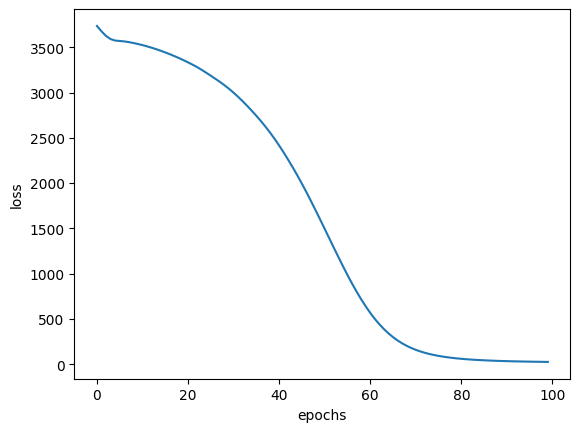

In [1307]:
plt.plot(range(epochs),losses)
plt.ylabel("loss")
plt.xlabel("epochs")

In [1308]:
with torch.no_grad():
  y_eval = model.forward(torch.nan_to_num(X_test)).squeeze(1)
  loss = criterion(y_eval,y_test)

In [1309]:
loss

tensor(490.7185)

In [1310]:
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(torch.nan_to_num(X_test)):
        y_pred = model.forward(data)

        if y_pred.argmax().item() == y_test[i]:
            correct += 1
        total += 1

accuracy = correct / total * 100
print(f'Accuracy: {accuracy}')

Accuracy: 58.63636363636363


In [1311]:
seniors = pd.read_csv('seniors.csv')

In [1312]:
seniors.head()

,NAME,SEX,AGES,ADMISSION MODE,CGPA - 1,CGPA-2,CLUB / DEPARTMENT,BOARD STUDIED,DAYS SINCE LAST SHOWER,BIRTHDAY,TREATS GIVEN,HAS A S/O ?,ATTENDS LECTURES,CHARACTER,PIZZERIA EXPENDITURE (annual),GRAMS / MONTH
0,Vaasu,female,18,BOARD TOPPER,3.24,4,SUTT,CBSE,14,9/15/2006,0,NO,YES,GHOT,20898,2.5
1,Rajat,male,19,BITSAT,6.45,6,SUTT,CBSE,8,7/23/2005,1,YES,YES,LITE,11695,5.7
2,Akhil,male,16,BITSAT,6.23,7,SUTT,CBSE,10,4/10/2007,3,NO,NO,LITE,16116,22.0
3,Yash,male,17,BITSAT,8.43,10,SUTT,CBSE,4,7/18/2007,4,NO,YES,LITE,13938,0.8
4,Yashwardhan,male,17,BITSAT,3.76,6,SUTT,CBSE,13,7/13/2007,3,YES,YES,LITE,18635,5.4


In [1313]:
X_sen = seniors.drop(['BIRTHDAY', 'DAYS SINCE LAST SHOWER', 'TREATS GIVEN','PIZZERIA EXPENDITURE (annual)', 'NAME'], axis=1)

In [1314]:
#encoding the categorical data using one hot encoding
#independent variable
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# dataset[' CLUB / DEPARTMENT'].replace('', 'NA', inplace=True)

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['SEX', 'ADMISSION MODE', ' CLUB / DEPARTMENT', 'BOARD STUDIED', ' HAS A S/O ?', 'ATTENDS LECTURES','CHARACTER'])], remainder='passthrough')
X_sen = np.array(ct.fit_transform(X_sen))

In [1315]:
from sklearn.preprocessing import MinMaxScaler

columns_to_norm = [1,3,4,10]
scaler = MinMaxScaler()
X_sen[:, columns_to_norm] = scaler.fit_transform(X_sen[:, columns_to_norm])
X_sen = X_sen.astype(np.float32)

In [1316]:
X_sen = torch.FloatTensor(X_sen)

In [1317]:
torch.manual_seed(70)
in_features_sen=X_sen.shape[1]
model_sen = Model(in_features_sen)

In [1318]:
with torch.no_grad():
    for i, data in enumerate(torch.nan_to_num(X_sen)):
        y_pred = model_sen.forward(data)
        if y_pred < 0.5:
            print(0)
        else:
          print(1)


0
0
0
0
0
0
0
0
0
0
0
